# Introduction to Brian part 2: Synapses

*Credit: The first three notebooks from week3 are part of the [Brian2 documentation]([brian2.readthedocs.io](https://brian2.readthedocs.io/en/stable/))* with minor changes.



If you haven't yet read part 1: Neurons, go read that now.

As before we start by importing the Brian package and setting up matplotlib for IPython:

In [1]:
!pip3 install brian2
from brian2 import *


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## The simplest Synapse

Once you have some neurons, the next step is to connect them up via synapses. We'll start out with doing the simplest possible type of synapse that causes an instantaneous change in a variable after a spike.

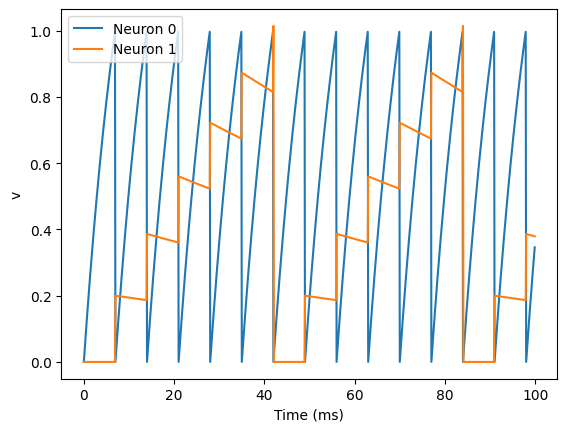

In [2]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms # If you wanted a single value of tau for all the neurons: G.tau = 100*ms

S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

There are a few things going on here. First of all, let's recap what is going on with the ``NeuronGroup``. We've created two neurons, each of which has the same differential equation but different values for parameters I and tau. Neuron 0 has ``I=2`` and ``tau=10*ms`` which means that is driven to repeatedly spike at a fairly high rate. Neuron 1 has ``I=0`` and ``tau=100*ms`` which means that on its own - without the synapses - it won't spike at all (the driving current I is 0). You can prove this to yourself by commenting out the two lines that define the synapse.

Next we define the synapses: ``Synapses(source, target, ...)`` means that we are defining a synaptic model that goes from ``source`` to ``target``. In this case, the source and target are both the same, the group ``G``. The syntax ``on_pre='v_post += 0.2'`` means that when a spike occurs in the presynaptic neuron (hence ``on_pre``) it causes an instantaneous change to happen ``v_post += 0.2``. The ``_post`` means that the value of ``v`` referred to is the post-synaptic value, and it is increased by 0.2. So in total, what this model says is that whenever two neurons in G are connected by a synapse, when the source neuron fires a spike the target neuron will have its value of ``v`` increased by 0.2.

However, at this point we have only defined the synapse model, we haven't actually created any synapses. The next line ``S.connect(i=0, j=1)`` creates a synapse from neuron 0 to neuron 1.

## Adding a weight

In the previous section, we hard coded the weight of the synapse to be the value 0.2 by indicating `on_pre='v_post += 0.2'`, but often we would to allow this to be different for different synapses. We do that by introducing synapse equations, we use tha argument ` on_pre='v_post += w'` in the synapses model and then specify the synaptic values values $w$:

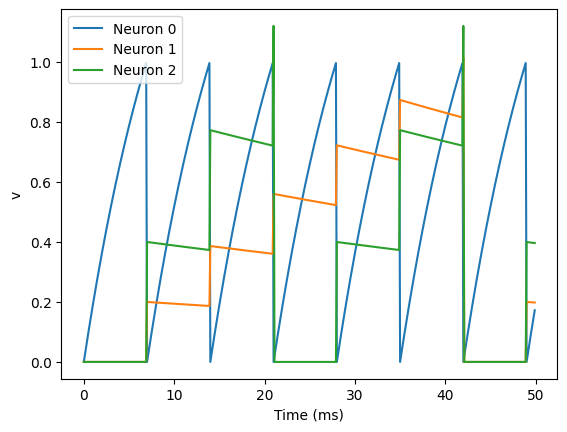

In [3]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0] # The input current to each neuron of the population
G.tau = [10, 100, 100]*ms # The membrane time constants of each neuron of the population

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

This example behaves very similarly to the previous example, but now there's a synaptic weight variable ``w``. The string ``'w : 1'`` is an equation string, precisely the same as for neurons, that defines a single dimensionless parameter ``w``. We changed the behaviour on a spike to ``on_pre='v_post += w'`` now, so that each synapse can behave differently depending on the value of ``w``. To illustrate this, we've made a third neuron which behaves precisely the same as the second neuron, and connected neuron 0 to both neurons 1 and 2. We've also set the weights via ``S.w = 'j*0.2'``. When ``i`` and ``j`` occur in the context of synapses, ``i`` refers to the source neuron index, and ``j`` to the target neuron index. So this will give a synaptic connection from 0 to 1 with weight ``0.2=0.2*1`` and from 0 to 2 with weight ``0.4=0.2*2``.

### Exercise

- Comment out the lines defined the synapses and re-run the simulation. How does this affect the resulting activity of the population?

## More complex connectivity

So far, we specified the synaptic connectivity explicitly, but for larger networks this isn't usually possible. For that, we usually want to specify some condition.

In [4]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=1.0)

Here we've created a dummy neuron group of N neurons and a dummy synapses model that doens't actually do anything just to demonstrate the connectivity. The line ``S.connect(condition='i!=j', p=1.0)`` will connect all pairs of neurons ``i`` and ``j`` with probability 100% as long as the condition ``i!=j`` holds. So, how can we see that connectivity? Here's a little function that will let us visualise it.

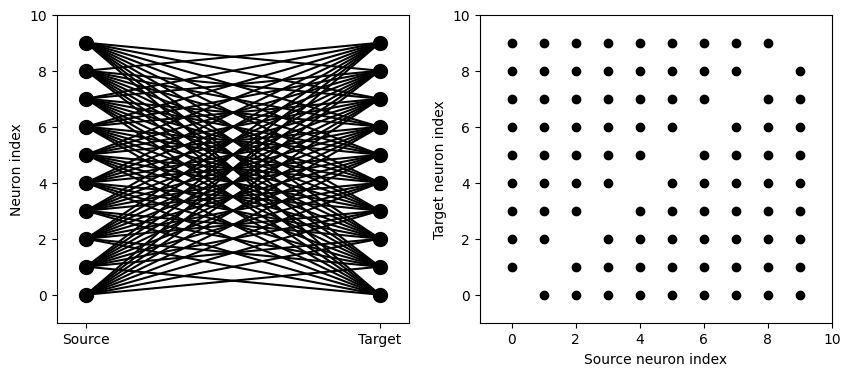

In [5]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
visualise_connectivity(S)

There are two plots here. On the left hand side, you see a vertical line of circles indicating source neurons on the left, and a vertical line indicating target neurons on the right, and a line between two neurons that have a synapse. On the right hand side is another way of visualising the same thing. Here each black dot is a synapse, with x value the source neuron index, and y value the target neuron index.

Let's see how these figures change as we change the probability of a connection:

WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/3703857024.py', line 5, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]


WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/3703857024.py', line 4, in <module>
    G = NeuronGroup(N, 'v:1') [brian2.core.base.unused_brian_object]


WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/2521570691.py', line 7, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]


WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/2521570691.py', line 7, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]


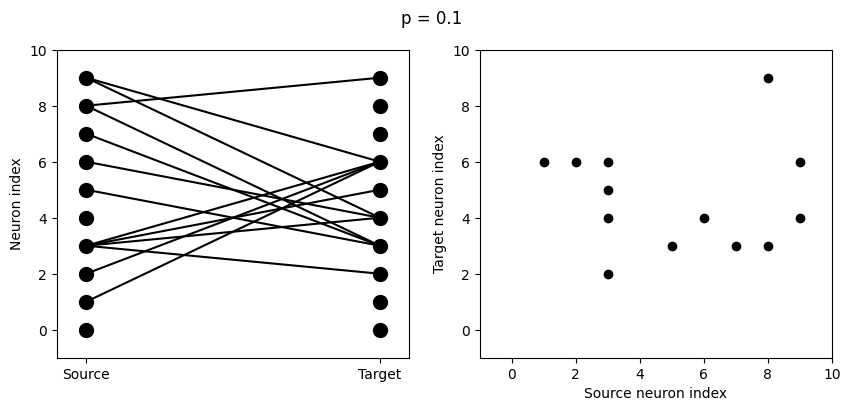

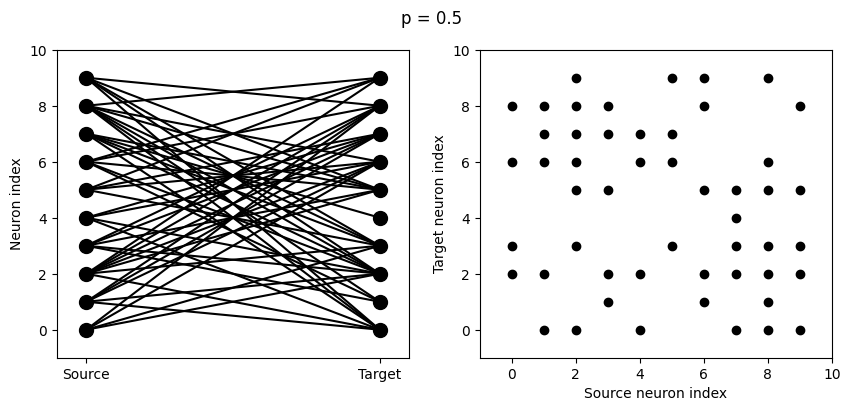

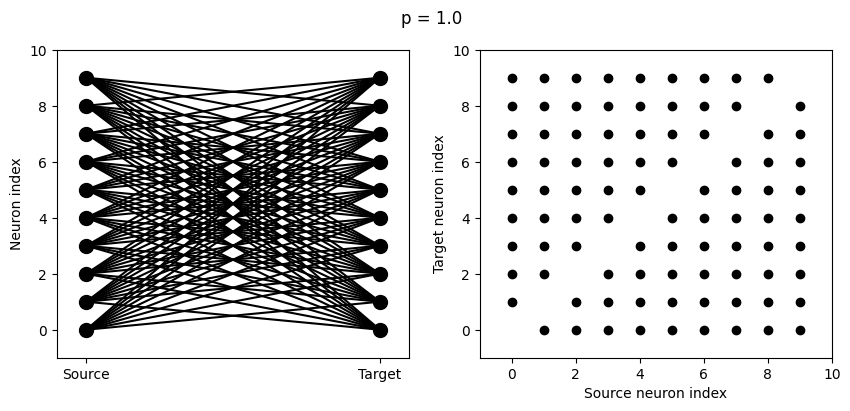

In [6]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p));

And let's see what another connectivity condition looks like. This one will only connect neighbouring neurons.

WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/2521570691.py', line 7, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]


WARNING    The object 'neurongroup_2' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/2521570691.py', line 4, in <module>
    G = NeuronGroup(N, 'v:1') [brian2.core.base.unused_brian_object]


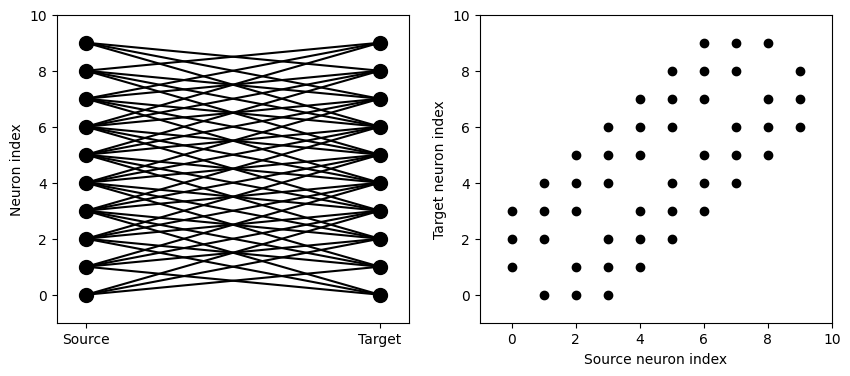

In [7]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j')
visualise_connectivity(S)

## Creating synapses via weight matrix

Another option to define the synapses of a network is explicitly providing a weight matrix.

We start by sampling a random connectivity matrix:

In [8]:
random_connectivity = np.random.uniform(low=-0.01, high=0.01, size=(N,N))
print(random_connectivity)

[[-1.42719184e-03  2.50740449e-03 -4.66472101e-03  6.90049313e-03
  -3.77741336e-03  3.15218249e-03  3.66823914e-03 -8.57921533e-03
   7.10354905e-03 -5.43408674e-03]
 [-4.76509145e-03  4.00453454e-04  7.29927228e-03 -5.84942229e-04
   5.90492905e-03  2.54671939e-03  8.25911336e-03 -2.07537588e-03
  -4.18694521e-04 -2.19715799e-03]
 [-3.89215846e-03  2.62342661e-03 -8.46534926e-03  4.44274833e-04
   1.22723426e-03 -7.69525417e-03  9.59011279e-03 -4.46123825e-08
  -3.76129653e-03  1.56615900e-03]
 [-9.27777183e-03  1.18047720e-03  4.44689893e-05  7.41107638e-03
  -8.68388380e-03  1.72609572e-03  5.37744605e-04 -6.87138389e-03
  -8.62682734e-03 -2.24467321e-03]
 [-2.63200125e-03 -8.89006228e-03  2.49438365e-03 -4.93506452e-03
  -2.88577443e-03 -4.54573931e-03 -6.91754060e-03  1.62773398e-03
  -9.70636860e-04 -8.54907088e-03]
 [ 9.06269119e-03  5.72513877e-03  4.42776558e-04  2.85652344e-03
  -8.30673437e-03 -3.90445882e-03  4.37815286e-03 -8.58018689e-04
  -5.67927397e-03  5.22718028e-03

In order to use the random values as the network connectivity:

In [9]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G, model='w : 1')
S.connect() 
S.w = random_connectivity.flatten()

WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/2320515699.py', line 6, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]


WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/2320515699.py', line 4, in <module>
    G = NeuronGroup(N, 'v:1') [brian2.core.base.unused_brian_object]


Notice a few things from the code:

- We had to add the argument `model='w : volt'` when creating the synapses.
- We had to flatten the random connectivity matrix 
- We had to add the units, in this case `mV`.

### Exercise 

- Add SpikeMonitor to track the spiking activity of one of the previously simulated populations and create a raster plot.

In [10]:
## Your code here

#### Bonus exercises

Create a population of 100 neurons with the following properties:
 - A weight matrix sampled from a Normal distribution $N(0,1)mV$ 
 - Initialize the neuron membranes potentials with random values from an uniform distribution $U(0,20)mV$
 - All the neuron have a constant input current of $25mV$
 - Refractory period of $2ms$, reset voltage of $0mV$, a firing threshold of $20mV$ and a membrane time scale of $20mS$.

Run the simulation for 0.5s and create a raster plot.

In [11]:
## Your code here

#### Bonus exercise 2: Simulation of a balance network

In the previous exercises we have been creating neuron populations and connecting them to themselves. Now, we will create two different populations —one of excitatory neurons and one inhibitory— and connect them to each other.

Create two two populations of neurons $G_{exct}$ and $G_{inhb}$ using the same parameters indicated in the previous exercise, except:

- The connectivity of $G_{exct}$ should be sampled from on a positive range, eg. from $U(0,20)mV$ while the inhibitory population $G_{exct}$ should have a connectivity with negative weights, eg. $U(-20,0)mV$

- Simulate the resulting network and make the raster plot for each of the populations.

In [12]:
## Your code here

## Bonus content: Introducing a delay

So far, the synapses have been instantaneous, but we can also make them act with a certain delay.

WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/1705174122.py', line 5, in <module>
    S = Synapses(G, G, model='w : 1') [brian2.core.base.unused_brian_object]


WARNING    The object 'neurongroup_2' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/1705174122.py', line 4, in <module>
    G = NeuronGroup(N, 'v:1') [brian2.core.base.unused_brian_object]


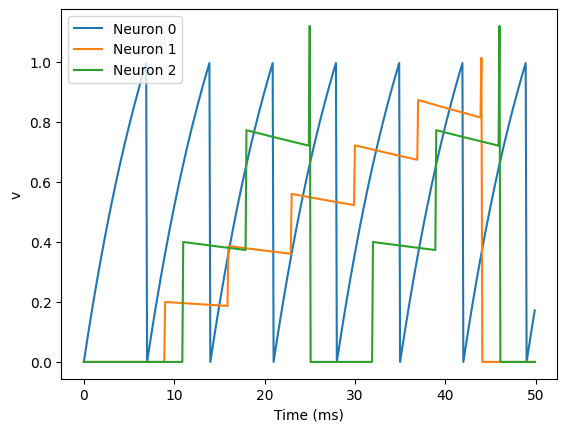

In [13]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend()

As you can see, that's as simple as adding a line ``S.delay = 'j*2*ms'`` so that the synapse from 0 to 1 has a delay of 2 ms, and from 0 to 2 has a delay of 4 ms.

## Bonus content: More complex synapse models: STDP

*This section of the notebook is optional, come to back to if you want after completing notebook 3 of this week.*

Brian's synapse framework is very general and can do things like short-term plasticity (STP) or spike-timing dependent plasticity (STDP). Let's see how that works for STDP.

STDP is normally defined by an equation something like this:

$$\Delta w = \sum_{t_{pre}} \sum_{t_{post}} W(t_{post}-t_{pre})$$

That is, the change in synaptic weight w is the sum over all presynaptic spike times $t_{pre}$ and postsynaptic spike times $t_{post}$ of some function $W$ of the difference in these spike times. A commonly used function $W$ is:

$$W(\Delta t) = \begin{cases}
A_{pre} e^{-\Delta t/\tau_{pre}} & \Delta t>0 \\
A_{post} e^{\Delta t/\tau_{post}} & \Delta t<0
\end{cases}$$

This function looks like this:

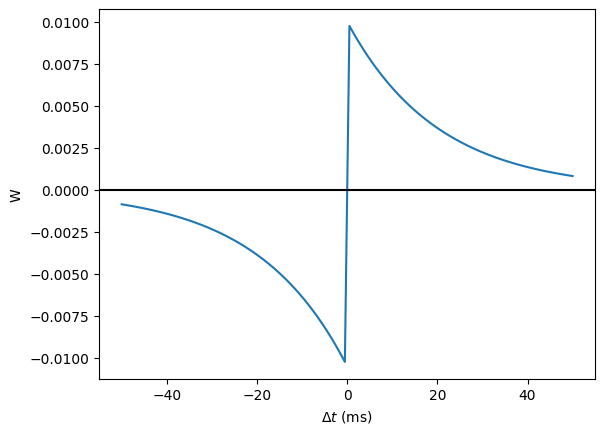

In [14]:
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre*1.05
delta_t = linspace(-50, 50, 100)*ms
W = where(delta_t>0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
plot(delta_t/ms, W)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k');

Simulating it directly using this equation though would be very inefficient, because we would have to sum over all pairs of spikes. That would also be physiologically unrealistic because the neuron cannot remember all its previous spike times. It turns out there is a more efficient and physiologically more plausible way to get the same effect.

We define two new variables $a_{pre}$ and $a_{post}$ which are "traces" of pre- and post-synaptic activity, governed by the differential equations:
$$
\begin{aligned}
\tau_{pre}\frac{\mathrm{d}}{\mathrm{d}t} a_{pre} &= -a_{pre}\\
\tau_{post}\frac{\mathrm{d}}{\mathrm{d}t} a_{post} &= -a_{post}
\end{aligned}
$$

When a presynaptic spike occurs, the presynaptic trace is updated and the weight is modified according to the rule:

$$
\begin{aligned}
a_{pre} &\rightarrow a_{pre}+A_{pre}\\
w &\rightarrow w+a_{post}
\end{aligned}
$$

When a postsynaptic spike occurs:

$$
\begin{aligned}
a_{post} &\rightarrow a_{post}+A_{post}\\
w &\rightarrow w+a_{pre}
\end{aligned}
$$

To see that this formulation is equivalent, you just have to check that the equations sum linearly, and consider two cases: what happens if the presynaptic spike occurs before the postsynaptic spike, and vice versa.

Now that we have a formulation that relies only on differential equations and spike events, we can turn that into Brian code.

In [15]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(1, 'v:1', threshold='v>1', reset='')

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')

There are a few things to see there. Firstly, when defining the synapses we've given a more complicated multi-line string defining three synaptic variables (``w``, ``apre`` and ``apost``). We've also got a new bit of syntax there, ``(event-driven)`` after the definitions of ``apre`` and ``apost``. What this means is that although these two variables evolve continuously over time, Brian should only update them at the time of an event (a spike). This is because we don't need the values of ``apre`` and ``apost`` except at spike times, and it is more efficient to only update them when needed.

Next we have a ``on_pre=...`` argument. The first line is ``v_post += w``: this is the line that actually applies the synaptic weight to the target neuron. The second line is ``apre += Apre`` which encodes the rule above. In the third line, we're also encoding the rule above but we've added one extra feature: we've clamped the synaptic weights between a minimum of 0 and a maximum of ``wmax`` so that the weights can't get too large or negative. The function ``clip(x, low, high)`` does this.

Finally, we have a ``on_post=...`` argument. This gives the statements to calculate when a post-synaptic neuron fires. Note that we do not modify ``v`` in this case, only the synaptic variables.

Now let's see how all the variables behave when a presynaptic spike arrives some time before a postsynaptic spike.

WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/2371042259.py', line 8, in <module>
    G = NeuronGroup(1, 'v:1', threshold='v>1', reset='') [brian2.core.base.unused_brian_object]


WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/l3/kmpmcyc11s55nh1p5qj8dr8r0000gp/T/ipykernel_33428/2371042259.py', line 10, in <module>
    S = Synapses(G, G, [brian2.core.base.unused_brian_object]


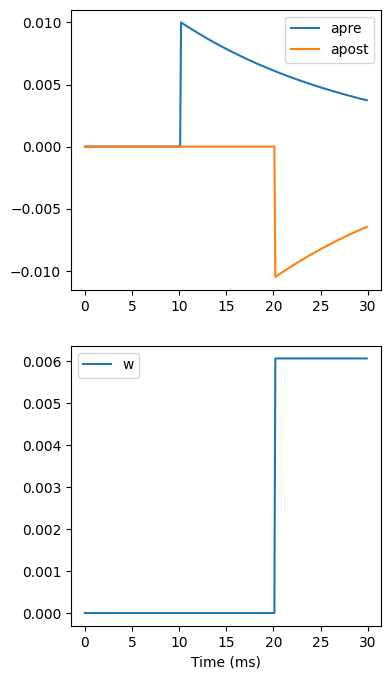

In [16]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

A couple of things to note here. First of all, we've used a trick to make neuron 0 fire a spike at time 10 ms, and neuron 1 at time 20 ms. Can you see how that works?

Secondly, we've replaced the ``(event-driven)`` by ``(clock-driven)`` so you can see how ``apre`` and ``apost`` evolve over time. Try reverting this change and see what happens.

Try changing the times of the spikes to see what happens.

Finally, let's verify that this formulation is equivalent to the original one.

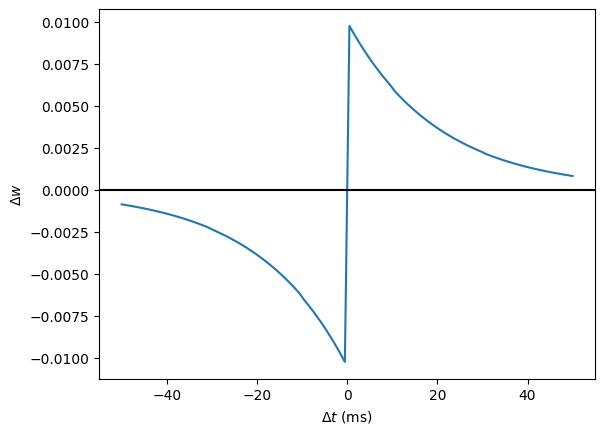

In [17]:
start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');